## JAX and Elegy image classifier


This is a simple example of JAX and Elegy image classifier. Here I am using transfer learning through bottleneck features. The purpose of this is the ability to use any net for featuring extraction, and then build the upper layers with JAX and Elegy, because not all famous nets are implemented in JAX.

In [1]:
import jax
import glob
import numpy as np
import jax.numpy as jnp

import elegy
import optax



/Users/alejandro/opt/anaconda3/envs/jax_elegy/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [14]:
class_names = ['no_damages', 'car_damage']
bottleneck_path = 'data/features/vgg19_bottleneck.npz'

features = np.load(bottleneck_path)
features['train'].shape[1:]

(7, 7, 512)

In [3]:
# I selected all the train_features except the last three,
# because they are not included in the train_targes.

train_features = features['train'][:-3]
test_features = features['test']

In [4]:
train_targets = np.load('data/labels/train_targets.npy')[:, 0].astype(np.int32)
test_targets = np.load('data/labels/test_targets.npy')[:, 0].astype(np.int32)

In [5]:
# Model architecture

class ModelArch(elegy.Module):

    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        GAP = lambda x: jnp.mean(x, axis=(1, 2))
        x = elegy.module.to_module(GAP)(name="global_average_pooling")(x)
        x = elegy.nn.Dropout(0.3)(x)
        x = elegy.nn.Linear(2, dtype=jnp.float32)(x)
        return x

In [6]:
# Here you can play with the different loss function, optimizers....

model = elegy.Model(
    module=ModelArch(),
    loss=[
        elegy.losses.SparseCategoricalCrossentropy(from_logits=True),
        elegy.regularizers.GlobalL2(l=1e-5),
    ],
    metrics=elegy.metrics.SparseCategoricalAccuracy(),
    optimizer=optax.rmsprop(1e-3),
)

In [7]:
model.summary(train_features[:1])


╒═════════════════════════════════════╤═════════════════════════╤═════════════════╤═════════════════╕
│ Layer                               │ Outputs Shape           │ Trainable       │   Non-trainable │
│                                     │                         │ Parameters      │      Parameters │
╞═════════════════════════════════════╪═════════════════════════╪═════════════════╪═════════════════╡
│ Inputs                              │ (1, 7, 7, 512)  float32 │ 0               │               0 │
├─────────────────────────────────────┼─────────────────────────┼─────────────────┼─────────────────┤
│ global_average_pooling  (<lambda>)  │ (1, 512)        float32 │ 0               │               0 │
├─────────────────────────────────────┼─────────────────────────┼─────────────────┼─────────────────┤
│ dropout                 (Dropout)   │ (1, 512)        float32 │ 0               │               0 │
├─────────────────────────────────────┼─────────────────────────┼────────────────

In [8]:
# Here you can play with the different arguments for fit, changing, batch size, including validation data,
# adding callbacks....

model.fit(train_features, train_targets, epochs=8)

Epoch 1/8
58/58 [==============================] - 1s 20ms/step - l2_regularization_loss: 1.6101e-05 - loss: 1.0211 - sparse_categorical_accuracy: 0.7408 - sparse_categorical_crossentropy_loss: 1.0211
Epoch 2/8
58/58 [==============================] - 0s 2ms/step - l2_regularization_loss: 1.5662e-05 - loss: 0.5808 - sparse_categorical_accuracy: 0.8283 - sparse_categorical_crossentropy_loss: 0.5808
Epoch 3/8
58/58 [==============================] - ETA: 0s - l2_regularization_loss: 1.5258e-05 - loss: 0.5445 - sparse_categorical_accuracy: 0.8393 - sparse_categorical_crossentropy_loss: 0.544 - 0s 2ms/step - l2_regularization_loss: 1.5226e-05 - loss: 0.5109 - sparse_categorical_accuracy: 0.8495 - sparse_categorical_crossentropy_loss: 0.5109
Epoch 4/8
58/58 [==============================] - 0s 2ms/step - l2_regularization_loss: 1.4929e-05 - loss: 0.4080 - sparse_categorical_accuracy: 0.8630 - sparse_categorical_crossentropy_loss: 0.4079
Epoch 5/8
58/58 [==============================] - 0s

In [9]:
predictions = np.argmax(model.predict(test_features), axis=1)

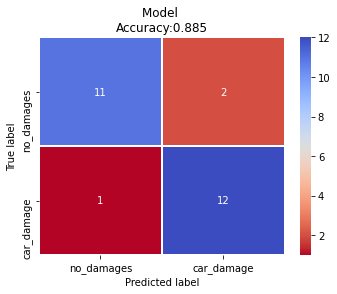

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

cm = confusion_matrix( test_targets, predictions) 

cm_df = pd.DataFrame(cm,
                     index = ['no_damages', 'car_damage'], 
                     columns = ['no_damages', 'car_damage'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, cmap="coolwarm_r",annot=True,linewidths=0.5)
plt.title('Model \nAccuracy:{0:.3f}'.format(accuracy_score(test_targets,predictions)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
from keras.preprocessing import image
from features_extractor import extract_VGG19


def path_to_tensor(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    
    x = image.img_to_array(img)

    return np.expand_dims(x, axis=0)


def make_file_prediction(img_path = 'data/sample_images/car_2.jpg'):

    img_tensor = path_to_tensor(img_path)
    img_tensor_features = extract_VGG19(img_tensor)
    
    prediction = model.predict(img_tensor_features)

    class_predicted = class_names[np.argmax(prediction, axis=1)[0]]
    
    return class_predicted

In [25]:
for file_path in glob.glob('data/sample_images/*.jpg'):
    print(file_path.split('/')[-1])
    print(make_file_prediction(file_path))
    print('-----------')
    print()

car_1.jpg
no_damages
-----------

car_damage_1.jpg
car_damage
-----------

car_2.jpg
no_damages
-----------

car_damage_2.jpg
car_damage
-----------

